In [61]:
# Ref:
#    https://www.oreilly.com/ideas/sentiment-analysis-with-apache-mxnet
#    https://nlp.stanford.edu/projects/glove/     
        
# Required imports
import numpy as np
import re
import itertools
from collections import Counter
import mxnet as mx
import numpy as np
import cv2
import matplotlib.pyplot as plt
import logging 
from sklearn.model_selection import train_test_split
%matplotlib notebook

from bhtsne import tsne

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [62]:
# loading the data from files
# Data: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

def read_files(foldername):
    import os
    sentiments = []
    filenames = os.listdir(os.curdir + "/" + foldername)
    for file in filenames:
        with open(foldername+"/"+file,"r", encoding="utf8") as pos_file:
            data = pos_file.read().replace('\n','')
            sentiments.append(data)
    return sentiments

foldername = "aclImdb/train/pos"
positive_sentiment = read_files(foldername)

foldername = "aclImdb/train/neg"
negative_sentiment = read_files(foldername)

positive_labels = [1 for _ in positive_sentiment]
negative_labels = [0 for _ in negative_sentiment]

In [63]:
# Some string preprocessing
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ", string)
    string = re.sub(r"\)", " ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r",", " ", string)
    string = re.sub(r"'", " ", string)
    string = re.sub(r"\[", " ", string)
    string = re.sub(r"\]", " ", string)
    return string.strip().lower()

In [64]:
#create a dict of word and their count in entrie dataset{word:count}

word_counter = Counter()
def create_count(sentiments):
    idx = 0
    for line in sentiments:
        for word in (clean_str(line)).split():
            if word not in word_counter.keys():
                word_counter[word] = 1
            else:
                word_counter[word] += 1
                
#Assigns a unique a number for each word (sorted by descending order based on the frequency of occurrence)
# and returns a word_dict
def create_word_index():
    idx = 0
    word_dict = {}
    for word in word_counter.most_common():
        word_dict[word[0]] = idx
        idx += 1
    return word_dict

model_path = "models"
all_sentiments = positive_sentiment + negative_sentiment
all_labels = positive_labels + negative_labels
create_count(all_sentiments)
word_dict = create_word_index()
#create a reverse index from a number to the word 
idx2word = {v: k for k, v in word_dict.items()}

In [65]:
#Creates a encoded sentences. 
#Assigns the unique id from wordict to the words in the sentences
def encoded_sentences(input_file, word_dict):
    output_string = []
    for line in input_file:
        output_line = []
        for word in (clean_str(line)).split():
            if word in word_dict:
                output_line.append(word_dict[word])
        output_string.append(output_line)
    return output_string

def decode_sentences(input_file, word_dict):
    output_string = []
    for line in input_file:
        output_line = ''
        for idx in line:
            ouput_line += idx2word[idx] + ' '
        output_string.append(output_line)
    return output_string

#Pad the sequences to maxlen.
#if sentences is greater than maxlen, truncates the sentences
#if sentences is less the 500, pads with value 0 (most commonly occurrning word)
def pad_sequences(sentences, maxlen=500, value=0):
    """
    Pads all sentences to the same length. The length is defined by maxlen.
    Returns padded sentences.
    """
    padded_sentences = []
    for sen in sentences:
        new_sentences = []
        if(len(sen) > maxlen):
            new_sentence = sen[:maxlen]
            padded_sentences.append(new_sentence)
        else:
            num_padding = maxlen - len(sen)
            new_sentence = np.append(sen, [value] * num_padding)
            padded_sentences.append(new_sentence)
    return padded_sentences

In [66]:
#Encodes the positive sentiment into sequence of number.
positive_encoded = encoded_sentences(positive_sentiment, word_dict)
negative_encoded = encoded_sentences(negative_sentiment, word_dict)

all_encoded = positive_encoded + negative_encoded

In [67]:
#setting the vocab size of the dictionary
#sequence length
#the embedding dimensions
vocab_size = 5000
seq_len = 500
embedding_dim = 50

#trn = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in train_set]
#test = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in test_set]
t_data = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in all_encoded]

In [68]:
#train+validation, test split
X_train_val, X_test, y_train_val, y_test_set = train_test_split(t_data, all_labels, test_size=0.3, random_state=42)

In [69]:
#train, validation split of data
X_train, X_val, y_train, y_validation = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

In [70]:
#statistics of sentences before padding
min_len = min(map(len, t_data))
max_len = max(map(len, t_data))
avg_len = sum(map(len, t_data)) / len(t_data)
print("The minimum length is:", min_len)
print("The maximum length is:", max_len)
print("The average length is:", avg_len)


The minimum length is: 10
The maximum length is: 2564
The average length is: 245.28632


In [71]:
#padding of sentences
trn = np.array(pad_sequences(X_train, maxlen=seq_len, value=0))
val = np.array(pad_sequences(X_val, maxlen=seq_len, value=0))
test = np.array(pad_sequences(X_test, maxlen=seq_len, value=0))
y_trn = np.array(y_train)
y_val = np.array(y_validation)
y_test = np.array(y_test_set)

In [72]:
#A simple dense model
input_x_1 = mx.sym.Variable('data')
embed_layer_1 = mx.sym.Embedding(data=input_x_1, input_dim=vocab_size, 
                                 output_dim=embedding_dim, name='vocab_embed')
flatten_1 = mx.sym.Flatten(data=embed_layer_1)
fc1_1 = mx.sym.FullyConnected(data = flatten_1, num_hidden=500, name="fc1")
relu3_1 = mx.sym.Activation(data=fc1_1, act_type="relu", name="relu3")
fc2_1 = mx.sym.FullyConnected(data=relu3_1, num_hidden=2, name="final_rc")
dense_1 = mx.sym.SoftmaxOutput(data=fc2_1, name='softmax')


In [73]:
#very useful for debugging. I am infering shapes of my network
arg_shape, output_shape, aux_shape = embed_layer_1.infer_shape(data=(1,500))
arg_shape2, output_shape2, aux_shape2 = flatten_1.infer_shape(data=(1, 500))

print(arg_shape2, output_shape2)

[(1, 500), (5000, 50)] [(1, 25000)]


In [74]:
#creating train_iter,val_iter,test_iter
batch_size = 64
train_iter = mx.io.NDArrayIter(trn, y_trn, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(val, y_val, batch_size, shuffle=True)
test_iter = mx.io.NDArrayIter(test, y_test, batch_size, shuffle=True)

In [75]:
#Create Adam optimiser
adam = mx.optimizer.create('adam')

#Checkpointing (saving the model). Make sure there is folder named model1 exist
# Create the folder `model1` first!
model_prefix = 'model1/chkpt'
checkpoint = mx.callback.do_checkpoint(model_prefix)

#Loading the module API. Previously mxnet used feedforward (deprecated)                           

model = mx.mod.Module(
    # context = mx.gpu(0),   # use GPU 0 for training; if you don't have a gpu use mx.cpu()
    context = mx.cpu(),
    symbol = dense_1, 
    data_names=['data']
)

#actually fits the model for 3 epochs.     
model.fit(
    train_iter,
    eval_data=val_iter,
    batch_end_callback=mx.callback.Speedometer(batch_size, 64),
    num_epoch=3,
    eval_metric='acc',
    optimizer=adam,
    epoch_end_callback=checkpoint
)

/home/jack/Applications/pythonEnv/python3/lib/python3.5/site-packages/mxnet/module/base_module.py:466: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.015625). Is this intended?
  optimizer_params=optimizer_params)
INFO:root:Epoch[0] Batch [64]	Speed: 159.70 samples/sec	accuracy=0.636538
INFO:root:Epoch[0] Batch [128]	Speed: 150.48 samples/sec	accuracy=0.821045
INFO:root:Epoch[0] Train-accuracy=0.849702
INFO:root:Epoch[0] Time cost=78.597
INFO:root:Saved checkpoint to "model1/chkpt-0001.params"
INFO:root:Epoch[0] Validation-accuracy=0.856363
INFO:root:Epoch[1] Batch [64]	Speed: 161.41 samples/sec	accuracy=0.920673
INFO:root:Epoch[1] Batch [128]	Speed: 153.66 samples/sec	accuracy=0.948730
INFO:root:Epoch[1] Train-accuracy=0.966270
INFO:root:Epoch[1] Time cost=75.988
INFO:root:Saved checkpoint to "model1/chkpt-0002.params"
INFO:root:Epoch[1] Validation-accuracy=0.825489
INFO:root:Epoch[2] Batch [64]	Speed:

In [76]:
# obtains the weights of embeding layer for visualizing
params = model.get_params()
print(params)
weights_dense_embed = model.get_params()[0]['vocab_embed_weight'].asnumpy()
weights_dense_embed = weights_dense_embed.astype('float64')

({'final_rc_weight': 
[[-0.08158711 -0.06357517  0.05898034  0.0636753   0.02117083  0.0533915
   0.05542684  0.05984816  0.02528815 -0.06650799 -0.04794089 -0.06423237
  -0.05848235  0.04211267  0.00889448 -0.04878311 -0.04058756  0.01389518
   0.08362561  0.0541679   0.049214    0.07554172  0.05085848 -0.04791768
  -0.04480472 -0.05399201  0.01871161  0.01599661  0.09502168  0.04018551
   0.00944471 -0.00455033 -0.07452807  0.07634738  0.03029447  0.02771634
   0.08318124 -0.0540061   0.0484111  -0.0588589   0.02959736  0.05636473
   0.06004874 -0.04669855  0.02846238  0.02260493  0.0046893  -0.07197969
   0.02881909 -0.0500968   0.05633336  0.0504617   0.06355552 -0.01572292
   0.11155934  0.05223484  0.04405447 -0.06337504  0.04235632  0.08826134
   0.00840203 -0.06407151 -0.06252837 -0.03809074 -0.05901534  0.01647939
   0.03632066  0.00403024 -0.05712355  0.0249681   0.05216287  0.05265627
   0.05435103  0.10978308 -0.05995865  0.0509702   0.02023269  0.08076026
   0.01368688 -0.

<IPython.core.display.Javascript object>


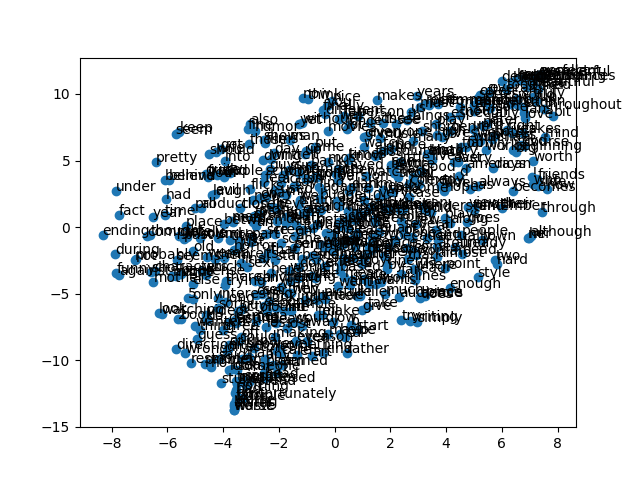

In [77]:
#tnse visualization for first 500 words
size = 500
Y = tsne(weights_dense_embed[:size])
plt.figure(0)
plt.scatter(Y[:, 0], Y[:, 1])
for idx, (x, y) in enumerate(zip(Y[:, 0], Y[:, 1])):
    plt.annotate(idx2word[idx], xy = (x, y), xytext=(0, 0), textcoords='offset points')

In [78]:
#measuring the accuracy of our model
acc = mx.metric.Accuracy()
model.score(val_iter, acc)
print(acc)

EvalMetric: {'accuracy': 0.8318900602409639}


In [79]:
# Load the model from the checkpoint , we are loading the 10 epoch
sym, arg_params, aux_params = mx.model.load_checkpoint(model_prefix, 3)

# Assign the loaded parameters to the module
mod = mx.mod.Module(symbol=sym, context=mx.cpu())
mod.bind(for_training = False, data_shapes=[('data', (1, 500))])
mod.set_params(arg_params, aux_params)

/home/jack/Applications/pythonEnv/python3/lib/python3.5/site-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [80]:
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

#a simple predict function
def predict(sen):
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(sen)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    return prob

#our custom sentences for testing
my_sen = ["the movie was awesome. Loved it"]
my_sen_encoded = encoded_sentences(my_sen, word_dict)
my_sen_encoded_padded = pad_sequences(my_sen_encoded)

In [81]:
output = predict(my_sen_encoded_padded)
#predicts the review is positive with 0.90 probability
print(output)

[ 0.01486197  0.98513806]


In [82]:
#a model with convolution kernel of 5 (5-grams)
input_x_2 = mx.sym.Variable('data')
embed_layer_2 = mx.sym.Embedding(data=input_x_2, input_dim=vocab_size, 
                                 output_dim=embedding_dim, name='vocab_embed')
conv_input_2 = mx.sym.Reshape(data=embed_layer_2, target_shape=(batch_size, 1, seq_len, embedding_dim))
conv1_2 = mx.sym.Convolution(data=conv_input_2, kernel=(5,embedding_dim), num_filter=100, name="conv1")
flatten_2 = mx.sym.Flatten(data=conv1_2)
fc2_2 = mx.sym.FullyConnected(data=flatten_2, num_hidden=2, name="final_fc")
convnet = mx.sym.SoftmaxOutput(data=fc2_2, name='softmax')

In [83]:
adam = mx.optimizer.create('adam')
#Checkpointing (saving the model). Make sure there is folder named model2 exist
model_prefix_2 = 'model2/chkpt'
checkpoint = mx.callback.do_checkpoint(model_prefix_2)

#Loading the module API. Previously mxnet used feedforward (deprecated)  
model_2 = mx.mod.Module(
    # context = mx.gpu(0),     # use GPU 0 for training; if you don't have a gpu use mx.cpu()
    context = mx.cpu(),
    symbol = convnet,
    data_names = ['data']
)
# fits the model for 3 epochs.   
model_2.fit(
    train_iter,
    eval_data = val_iter,
    batch_end_callback = mx.callback.Speedometer(batch_size, 64),
    num_epoch = 3, 
    eval_metric='acc',
    optimizer=adam,
    epoch_end_callback=checkpoint
)

/home/jack/Applications/pythonEnv/python3/lib/python3.5/site-packages/mxnet/module/base_module.py:466: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.015625). Is this intended?
  optimizer_params=optimizer_params)
INFO:root:Epoch[0] Batch [64]	Speed: 141.92 samples/sec	accuracy=0.654567
INFO:root:Epoch[0] Batch [128]	Speed: 149.18 samples/sec	accuracy=0.831543
INFO:root:Epoch[0] Train-accuracy=0.855655
INFO:root:Epoch[0] Time cost=82.949
INFO:root:Saved checkpoint to "model2/chkpt-0001.params"
INFO:root:Epoch[0] Validation-accuracy=0.857681
INFO:root:Epoch[1] Batch [64]	Speed: 149.10 samples/sec	accuracy=0.896154
INFO:root:Epoch[1] Batch [128]	Speed: 151.56 samples/sec	accuracy=0.909912
INFO:root:Epoch[1] Train-accuracy=0.906250
INFO:root:Epoch[1] Time cost=88.906
INFO:root:Saved checkpoint to "model2/chkpt-0002.params"
INFO:root:Epoch[1] Validation-accuracy=0.837726
INFO:root:Epoch[2] Batch [64]	Speed:

In [84]:
# a model with convolution filters of 3,4,5 (3-gram,4-grams,5-grams)
input_x_3 = mx.sym.Variable('data')
embed_layer_3 = mx.sym.Embedding(data=input_x_3, input_dim = vocab_size,
                                 output_dim=embedding_dim, name='vocab_embed')
conv_input_3 = mx.sym.Reshape(data=embed_layer_3, target_shape=(batch_size, 1 ,seq_len, embedding_dim))

# create convolution + (max) pooling layer for each filter operation
filter_list = [3, 4, 5] # the size of filters to use

num_filter = 100
pooled_outputs = []
for i, filter_size in enumerate(filter_list):
    convi = mx.sym.Convolution(data=conv_input_3, kernel=(filter_size, embedding_dim), num_filter=num_filter)
    relui = mx.sym.Activation(data=convi, act_type='relu')
    pooli = mx.sym.Pooling(data=relui, pool_type='max', kernel=(seq_len - filter_size + 1, 1), stride=(1,1))
    pooled_outputs.append(pooli)
    
# combine all pooled outputs
total_filters = num_filter * len(filter_list)
concat = mx.sym.Concat(*pooled_outputs, dim=1)

# reshape for next layer
h_pool_3 = mx.sym.Reshape(data=concat, target_shape=(batch_size, total_filters))
fc2_3 = mx.sym.FullyConnected(data=h_pool_3, num_hidden=2, name="final_fc")
convnet_combined = mx.sym.SoftmaxOutput(data=fc2_3, name='softmax')


In [85]:
adam = mx.optimizer.create('adam')

#Checkpointing (saving the model). Make sure there is folder named model3 exist
model_prefix_3 = 'model3/chkpt'
checkpoint = mx.callback.do_checkpoint(model_prefix_3)
                                       
#Loading the module API. Previously mxnet used feedforward (deprecated)                                       
model_3 =  mx.mod.Module(
    #context = mx.gpu(0),     # use GPU 0 for training; if you don't have a gpu use mx.cpu()
    context = mx.cpu(),
    symbol = convnet_combined,
    data_names=['data']
   )
                                       
#fits the model for 3 epochs.                                 
model_3.fit(
    train_iter,
    eval_data=val_iter, 
    batch_end_callback = mx.callback.Speedometer(batch_size, 64),
    num_epoch = 3, 
    eval_metric='acc',
    optimizer = adam,
    epoch_end_callback=checkpoint
)

/home/jack/Applications/pythonEnv/python3/lib/python3.5/site-packages/mxnet/module/base_module.py:466: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.015625). Is this intended?
  optimizer_params=optimizer_params)
INFO:root:Epoch[0] Batch [64]	Speed: 69.89 samples/sec	accuracy=0.588702
INFO:root:Epoch[0] Batch [128]	Speed: 72.36 samples/sec	accuracy=0.781250
INFO:root:Epoch[0] Train-accuracy=0.832341
INFO:root:Epoch[0] Time cost=171.093
INFO:root:Saved checkpoint to "model3/chkpt-0001.params"
INFO:root:Epoch[0] Validation-accuracy=0.834902
INFO:root:Epoch[1] Batch [64]	Speed: 70.58 samples/sec	accuracy=0.855288
INFO:root:Epoch[1] Batch [128]	Speed: 66.20 samples/sec	accuracy=0.893555
INFO:root:Epoch[1] Train-accuracy=0.910466
INFO:root:Epoch[1] Time cost=176.608
INFO:root:Saved checkpoint to "model3/chkpt-0002.params"
INFO:root:Epoch[1] Validation-accuracy=0.861634
INFO:root:Epoch[2] Batch [64]	Speed: 6

In [87]:
#loads glove word embedding 
def load_glove_index(loc):
    f = open(loc, encoding="utf8")
    embeddings_index={}
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

#creates word embedding matrix
def create_emb():
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_dict.items():
        if i >= vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
# glove.6B.zip: http://nlp.stanford.edu/data/glove.6B.zip
# https://nlp.stanford.edu/projects/glove/
embeddings_index = load_glove_index("glove/" + 'glove.6B.50d.txt')
embedding_matrix = create_emb();

<IPython.core.display.Javascript object>


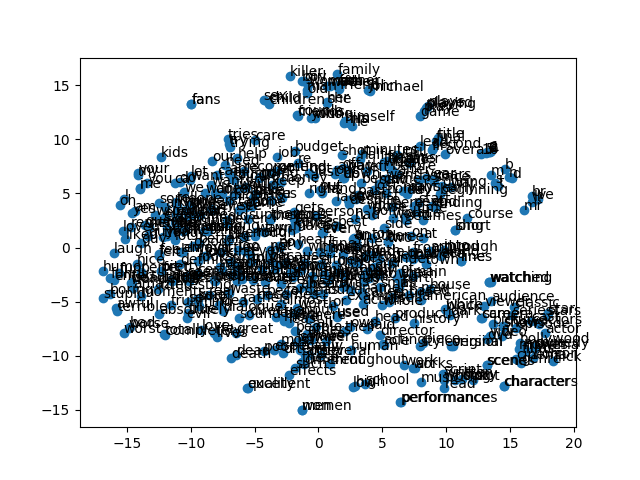

In [89]:
#visualization of word embedding.
size = 500
Y = tsne(embedding_matrix[:size])
plt.figure(1)
plt.scatter(Y[:,0], Y[:,1])
for idx, (x, y) in enumerate(zip(Y[:,0], Y[:,1])):
    plt.annotate(idx2word[idx], xy=(x, y), xytext=(0,0), textcoords='offset points')
    

In [90]:
#creates a model with convolution and pretrained word embedding.
weight_matrix = mx.nd.array(embedding_matrix)
input_x_3 = mx.sym.Variable('data')
the_emb_3 = mx.sym.Variable('weights') #the weight variable which will hold the pre trained embedding matrix
embed_layer_3 = mx.sym.Embedding(data=input_x_3, weight=the_emb_3, input_dim=vocab_size, 
                                 output_dim=embedding_dim, name='vocab_embed')
conv_input_3 = mx.sym.Reshape(data=embed_layer_3, target_shape=(batch_size, 1, seq_len, embedding_dim))
conv1_3 = mx.sym.Convolution(data=conv_input_3, kernel=(5, embedding_dim), num_filter=100, name="conv1")
flatten_3 = mx.sym.Flatten(data=conv1_3)
fc2_3 = mx.sym.FullyConnected(data=flatten_3, num_hidden=2, name="final_fc")
convnet_word2vec = mx.sym.SoftmaxOutput(data=fc2_3, name='softmax')

In [92]:
adam = mx.optimizer.create('adam')

#Checkpointing (saving the model). Make sure there is folder named model4 exist
model_prefix_3 = 'model4/chkpt'
checkpoint = mx.callback.do_checkpoint(model_prefix_3)
                                       
#Loading the module API. Previously mxnet used feedforward (deprecated)                                       
model_3 =  mx.mod.Module(
    # context = mx.gpu(0),     # use GPU 0 for training; if you don't have a gpu use mx.cpu()
    context = mx.cpu(), 
    symbol = convnet_word2vec,
     fixed_param_names =['weights'] # makes the weights variable non trainable. Back propagration will not update this variable
   )
                                       
#fits the model for 5 epochs.                                    
model_3.fit(
    train_iter,
    eval_data=val_iter, 
    batch_end_callback = mx.callback.Speedometer(batch_size, 64),
    num_epoch = 5, 
    eval_metric='acc',
    optimizer = adam,
    epoch_end_callback=checkpoint,
    arg_params={'weights': weight_matrix}, #loads the pretrained glove embedding to weights variable
    allow_missing=True
)

/home/jack/Applications/pythonEnv/python3/lib/python3.5/site-packages/mxnet/module/base_module.py:466: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.015625). Is this intended?
  optimizer_params=optimizer_params)
INFO:root:Epoch[0] Batch [64]	Speed: 215.44 samples/sec	accuracy=0.624760
INFO:root:Epoch[0] Batch [128]	Speed: 225.92 samples/sec	accuracy=0.687256
INFO:root:Epoch[0] Train-accuracy=0.687004
INFO:root:Epoch[0] Time cost=55.150
INFO:root:Saved checkpoint to "model4/chkpt-0001.params"
INFO:root:Epoch[0] Validation-accuracy=0.695783
INFO:root:Epoch[1] Batch [64]	Speed: 218.95 samples/sec	accuracy=0.724519
INFO:root:Epoch[1] Batch [128]	Speed: 223.31 samples/sec	accuracy=0.750488
INFO:root:Epoch[1] Train-accuracy=0.762649
INFO:root:Epoch[1] Time cost=55.678
INFO:root:Saved checkpoint to "model4/chkpt-0002.params"
INFO:root:Epoch[1] Validation-accuracy=0.684488
INFO:root:Epoch[2] Batch [64]	Speed: